# A/B TEST FOR A MOBILE GAME
<b><u>1. Dataset and variables</u></b>:
<br>
The dataset comes from Datacamp's project (<a href="https://www.kaggle.com/datasets/yufengsui/mobile-games-ab-testing">Link</a>) with 90,189 users installed and played the game Cookies Cats.
<br>
There are 5 variables:
<ul>
    <li><b>userid</b>: a unique number that identifies each player;</li>
    <li><b>version</b>: whether the player is assigned to control group (gate at level 30 - gate_30) or treatment group (gate at level 40 - gate_40). The gate here means an enforced break keeping players waiting for a non-trivial amount of time or they can make an in-app purchase to progress. The goal of A/B test is to analyze the impact of moving the gate from level 30 to level 40 on retention rate as well as each user's number of game rounds;</li>
    <li><b>sum_gamerounds</b>: the number of game rounds played by the player during the first 14 days after installing;</li>
    <li><b>retention_1</b>: whether the player returned and played 1 day after installing;</li>
    <li><b>retention_7</b>: whether the player returned and played 7 days after installing</li>
</ul>
<br>
The information below is about data types, missing values and how the data was organized:

In [3]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import shapiro,levene,ttest_ind,mannwhitneyu
%matplotlib inline

In [8]:
result = pd.read_csv('C:/Users/Admin/Python/Dataset/cookie_cats_data.csv')
print(10*"*" + "DATASET INFORMATION: \n")
print(result.info())
print("\n")
print(10*"*" + "FIRST 5 OBSERVATIONS: \n")
print(result.head())

**********DATASET INFORMATION: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB
None


**********FIRST 5 OBSERVATIONS: 

   userid  version  sum_gamerounds  retention_1  retention_7
0     116  gate_30               3        False        False
1     337  gate_30              38         True        False
2     377  gate_40             165         True        False
3     483  gate_40               1        False        False
4     488  gate_40             179         True         True


<b><u>2. Explanatory Statistics</u></b>:
<br>
90,189 users have been assigned in 'gate_30 version' group (44,700 users) and 'gate_40 version' group (45,489 users). 
<br>
As a first sight, the average number of game rounds played by each player <i>(sum_gamerounds)</i>, the 1-day retention rate <i>(retention_1)</i> and the 7-day retention rate <i>(retention_7)</i> of 'gate_30 version' group are higher than those of 'gate_40 version' group. Section 3 will perform test for the statistical significance of this difference.
<br>
The retention rate after 1 day of installing is around 44%-45% while it drops to 18%-19% after 7 days of installing.
<br>
The number of game rounds played by each player is left-skewed with 75% of the users play less than or equal to 51 rounds during 14 days. 4.42% of users just install the app and did not play any round. 

In [16]:
print(10*"*" + "SUMMARY STATISTICS: \n")
summary = result.groupby('version').agg({'userid':'count','sum_gamerounds':'mean','retention_1':'mean','retention_7':'mean'})
print(summary,"\n")
print(15*"*" + "Number of gamerounds: \n")
print(result['sum_gamerounds'].describe(),"\n")
print("Percentage of 0 game round: ",result[result['sum_gamerounds']==0]['userid'].count()/len(result)*100, '%')

**********SUMMARY STATISTICS: 

         userid  sum_gamerounds  retention_1  retention_7
version                                                  
gate_30   44700       52.456264     0.448188     0.190201
gate_40   45489       51.298776     0.442283     0.182000 

***************Number of gamerounds: 

count    90189.000000
mean        51.872457
std        195.050858
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max      49854.000000
Name: sum_gamerounds, dtype: float64 

Percentage of 0 game round:  4.42847797403231 %


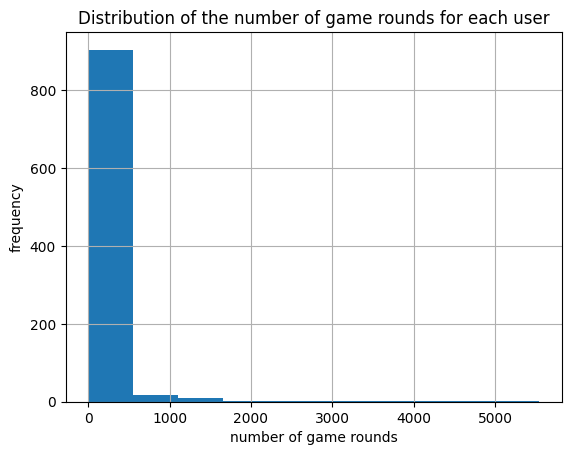

In [14]:
# Distribution of the number of game rounds for each user:
game_rounds = result.groupby('sum_gamerounds')['userid'].count()
game_rounds.hist()
plt.title("Distribution of the number of game rounds for each user")
plt.xlabel('number of game rounds')
plt.ylabel('frequency')
plt.show()

<b><u>3. A/B Test Result</u></b>:
<br>
To analyze the A/B test result of 3 metrics (<i>sum_gamerounds</i>, <i>retention_1</i>, <i>retention_7</i>):
<ul>
    <li><b>First</b>, we check whether the two groups'metrics is normal distributed or not (using Shapiro-Wilk test);</li>
    <li><b>Second</b>, we check whether the two groups'metrics have equal variance or not (using Levene test);</li>
    <li><b>Finally</b>, we use t-test or Mann_Whitney_U test to analyze the difference of metrics</li>
</ul>
<br>
We build a function containing 3 steps above and apply for 3 metrics. <br>
Testing results with alpha level of 5% (or confidence level of 95%) are below:

In [39]:
# Define function:
def ab_test(result,metric,p):
    print(5*"*" + "TESTING FOR %s :" % metric)
    #H0: Groups have normal distribution 
    print(10*"*" + "NORMAL DISTRIBUTION ASSUMPTION: ")
    p_gate30 = shapiro([result.loc[result['version'] == 'gate_30',metric]])[1]
    p_gate40 = shapiro([result.loc[result['version'] == 'gate_40',metric]])[1]
    
    print("p_value_gate30: %.5f" % p_gate30)
    if p_gate30 < p:
        print("Reject the Null Hypothesis that Gate_30 version's group doesn't have normal distribution at alpha level of ",p)
    else:
        print("Cannot reject the Null Hypothesis that Gate_30 version's group has normal distribution at alpha level of ",p)
    
    print("p_value_gate40: %.5f" % p_gate40)
    if p_gate40 < p:
        print("Reject the Null Hypothesis that Gate_40 version's group doesn't have normal distribution at alpha level of ",p)
    else:
        print("Cannot reject the Null Hypothesis that Gate_40 version's group has normal distribution at alpha level of ",p)
    #H0: Groups have equal variance
    print(10*"*" + "VARIANCE HOMOGENEOUS ASSUMPTION: ")
    p_levene = levene(result.loc[result['version'] == 'gate_30',metric],
                     result.loc[result['version'] == 'gate_40',metric])[1]
    print("p_value_levene: %.5f" % p_levene)
    if p_levene < p:
        print("Reject the Null Hypothesis that two groups have equal variance at alpha level of ",p)
    else:
        print("Cannot reject the Null Hypothesis that two groups have equal variance at alpha level of ",p)
    #H0: No statistical difference between 2 groups
    print(10*"*" + "CHECK FOR STATISTICAL DIFFERENCE: ")
    if(p_gate30 > p) & (p_gate40 > p) & (p_levene > p):
        p_ttest_1 = ttest_ind(result.loc[result['version'] == 'gate_30',metric],
                           result.loc[result['version'] == 'gate_40',metric],
                           equal_var = True)[1]
        print("ttest result: %.5f" % p_ttest_1)
        if p_ttest_1 > p:
            print("There is NO statistical difference between 2 versions at alpha level of ",p)
        else:
            print("There is statistical difference between 2 versions at alpha level of ",p)
    elif(p_gate30 > p) & (p_gate40 > p) & (p_levene < p):
        p_ttest_2 = ttest_ind(result.loc[result['version'] == 'gate_30',metric],
                           result.loc[result['version'] == 'gate_40',metric],
                           equal_var = False)[1]
        print("ttest result: %.5f" % p_ttest_2)
        if p_ttest_2 > p:
            print("There is NO statistical difference between 2 versions at alpha level of ",p)
        else:
            print("There is statistical difference between 2 versions at alpha level of ",p)
    else:
        print("Non-parametric Test: ")
        p_mann = mannwhitneyu(result.loc[result['version'] == 'gate_30',metric],
                     result.loc[result['version'] == 'gate_40',metric])[1]
        print("p_value_mannwhineyu: %.5f" % p_mann)
        if p_mann > p:
            print("There is NO statistical difference between 2 versions at alpha level of ",p)
        else:
            print("There is statistical difference between 2 versions at alpha level of ",p)
    print("\n")
#Testing results: 
print(ab_test(result,'retention_1',0.05))
print(ab_test(result,'retention_7',0.05))
print(ab_test(result,'sum_gamerounds',0.05))


*****TESTING FOR retention_1 :
**********NORMAL DISTRIBUTION ASSUMPTION: 
p_value_gate30: 0.00000
Reject the Null Hypothesis that Gate_30 version's group doesn't have normal distribution at alpha level of  0.05
p_value_gate40: 0.00000
Reject the Null Hypothesis that Gate_40 version's group doesn't have normal distribution at alpha level of  0.05
**********VARIANCE HOMOGENEOUS ASSUMPTION: 
p_value_levene: 0.07441
Cannot reject the Null Hypothesis that two groups have equal variance at alpha level of  0.05
**********CHECK FOR STATISTICAL DIFFERENCE: 
Non-parametric Test: 
p_value_mannwhineyu: 0.07441
There is NO statistical difference between 2 versions at alpha level of  0.05


None
*****TESTING FOR retention_7 :
**********NORMAL DISTRIBUTION ASSUMPTION: 
p_value_gate30: 0.00000
Reject the Null Hypothesis that Gate_30 version's group doesn't have normal distribution at alpha level of  0.05
p_value_gate40: 0.00000
Reject the Null Hypothesis that Gate_40 version's group doesn't have norma

At confidence level of 95%, there is no statistical difference between 2 groups' <i>sum_gamerounds</i> and <i>retention_1</i>, but the difference of <i>retention_7</i> is statistical with p_value of Mann-Whitney_U test is 0.00155.<br>
We also use bootstrap method to help visualize the difference.

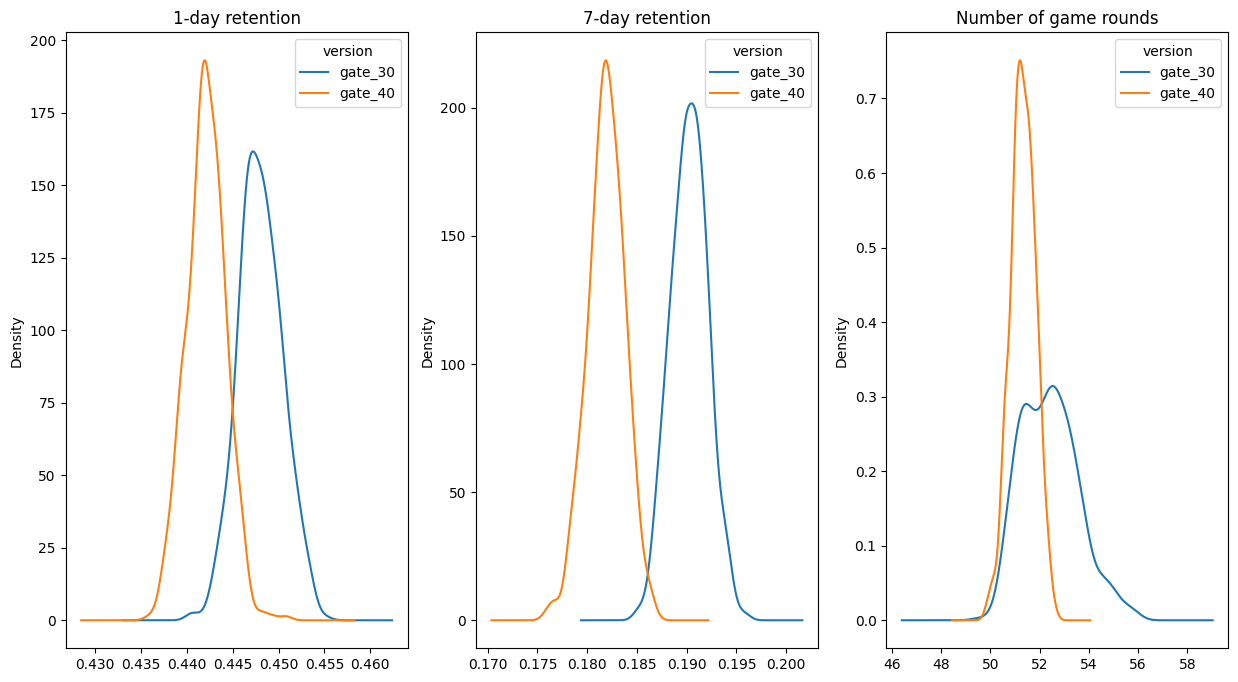

In [42]:
#Bootstrapping and plotting metrics:
boot_ret1 = [result.sample(frac=1,replace=True).groupby('version')['retention_1'].mean() for _ in range(500)]
boot_ret1 = pd.DataFrame(boot_ret1)

boot_ret7 = [result.sample(frac=1,replace=True).groupby('version')['retention_7'].mean() for _ in range(500)]
boot_ret7 = pd.DataFrame(boot_ret7)

boot_gamerounds = [result.sample(frac=1,replace=True).groupby('version')['sum_gamerounds'].mean() for _ in range(500)]
boot_gamerounds = pd.DataFrame(boot_gamerounds)

fig,ax = plt.subplots(1,3, figsize=(15,8))
boot_ret1.plot(kind='kde', title='1-day retention',ax=ax[0])
boot_ret7.plot(kind='kde', title='7-day retention', ax=ax[1])
boot_gamerounds.plot(kind='kde', title='Number of game rounds', ax=ax[2])
plt.show()

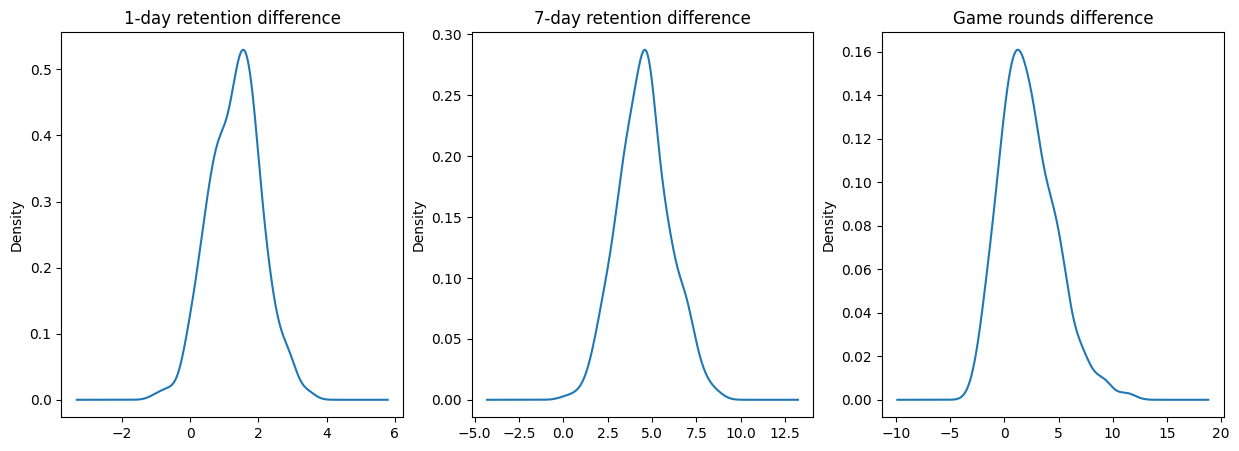

In [41]:
#Plotting the metrics difference:
boot_ret1['diff'] = (boot_ret1['gate_30'] - boot_ret1['gate_40'])/boot_ret1['gate_40']*100
boot_ret7['diff'] = (boot_ret7['gate_30'] - boot_ret7['gate_40'])/boot_ret7['gate_40']*100
boot_gamerounds['diff'] = (boot_gamerounds['gate_30'] - boot_gamerounds['gate_40'])/boot_gamerounds['gate_40']*100

fig,ax = plt.subplots(1,3,figsize=(15,5))
boot_ret1['diff'].plot(kind='kde',title='1-day retention difference',ax=ax[0])
boot_ret7['diff'].plot(kind='kde',title='7-day retention difference',ax=ax[1])
boot_gamerounds['diff'].plot(kind='kde',title='Game rounds difference',ax=ax[2])
plt.show()

<b><u>4. Conclusion:</u></b>
    <br>
    There is strong evidence that 7-day retention rate is higher when the gate is placed at level 30 than it is at level 40; therefore, to maintain higher retention rate, we should not move the gate. As we place the gate later, fewer people reach that level and they may get bored of the game.